# Masking Techniques - Experiments in Pandas

In [1]:
import matplotlib.pylab as plt
import pandas as pd

import cape_privacy as cape
from cape_privacy.pandas import dtypes
from cape_privacy.pandas import transformations as tfms

plt.style.use('seaborn')

This notebook illustrates how you can:
- Prototype the masking techniques in Pandas.
- Define a data privacy policy through human-readable policy files.
- Apply this data privacy policy to a Pandas DataFrame.

As an example, we experiment with the public [German credit card dataset](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). We just added some fake PII information (such as name, address, etc.) and quasi-identifiers (city, salary etc.) to make it more similar to a real dataset for which we would use these masking techniques. 

In [2]:
df = pd.read_csv('data/credit_with_pii.csv')
df.Application_date = pd.to_datetime(df.Application_date)

In [3]:
df.head()

,Name,City,Street_address,Salary,Application_date,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,Robert Fitzgerald,Greenmouth,349 Alexander Coves Apt. 799,36964.79,2018-08-03,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,Daniel Kim,North Jessica,349 Jesse Park Suite 888,87884.39,2018-08-07,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,Frederick Jordan,Lake Erika,389 Graham Drive Suite 973,41157.73,2018-05-14,49,male,1,own,little,NaN,2096,12,education,good
3,Tara Rojas,East Jessica,01579 Ramirez Drives Apt. 587,36214.80,2018-04-30,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,Gail Donovan,Randyport,467 Christopher Well,41353.49,2018-05-27,53,male,2,free,little,little,4870,24,car,bad


## Prototype the masking Techniques

Here are some questions you could ask yourself to figure out how to mask this dataset:
- Who can view this dataset?
- What are the direct and quasi identifiers?
- Is there sensitive data irrelevant for the task I could redact right away?
- Could I re-identify a person using the quasi identifiers (city, salary, age, etc.) and additional sources of information? 
- How much utility from this sensitive data do I need to maintain for this task?


One potential approach to protect the credit dataset could be to say that ‘name’ is irrelevant for the task, and therefore we should remove it. However, there’s another approach. We might want to count the number of unique people or clients in the dataset, or validate if there is one or several loans per client, and then validate the aggregation level of the dataset. For these reasons, you can apply the tokenizer, which will map each name to a unique token. Each name will be obfuscated, but the dataset will still maintain the correct user count.

The dataset also contains an individual’s address and city. If this location information is too granular or not useful for the task, we could simply remove these columns. Or, if we think the credit risk could vary based on the city, we could tokenize these fields instead. We won’t know the city name, however, we can still assess the predictive power of this variable if it is included in the model. 

Do we need to know the exact age of the client? Or would having a general idea of their age be sufficient to assess credit risk? If the latter, we can perturb age by adding a random value within a certain range (e.g., [-5, 5]). (Just keep in mind the amount of noise could impact the utility/accuracy of your model).

Even though the application date is not a direct identifier, if we know that only one person applied on a certain day, we could re-identify this person. We could perturb these dates by adding or removing days (e.g., within [-3, 3]) to help reduce the ability to link this column with other information or datasets. 

You could also tokenize the sex field. You probably don’t want to include this variable in your credit risk model. However, for fairness considerations, you should validate that people receive similar loan approval rates independent of their gender.

Finally, you can reduce the precision of salary, which could be considered sensitive information, by rounding it to the nearest 1000s. If you decide to include the debt ratio in your model, this transformation shouldn't really impact the outcome of your model.

Let’s see how it looks in code:

In [4]:
tokenize_name = tfms.Tokenizer()
tokenize_sex = tfms.Tokenizer(max_token_len=10)
perturb_age = tfms.NumericPerturbation(dtype=dtypes.Integer, min=-5, max=5)
perturb_application_date = tfms.DatePerturbation(frequency="DAY", min=-3, max=3)
redact_location = tfms.ColumnRedact(columns=["Street_address", "City"])
round_salary = tfms.NumericRounding(dtype=dtypes.Float, precision=-3)

In [5]:
def mask(df):
    df['Name'] = tokenize_name(df['Name'])
    df['Sex'] = tokenize_sex(df['Sex'])
    df['Age'] = perturb_age(df['Age'])
    df['Application_date'] = perturb_application_date(df['Application_date'])
    df['Salary'] = round_salary(df['Salary'])
    df = redact_location(df)
    return df

caped_df = mask(df)
caped_df.head()

,Name,Salary,Application_date,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,6716e654da4d658361af4a6b64b2d6cde0b93b0417af21...,37000.0,2018-08-03,67,f928895146,2,own,NaN,little,1169,6,radio/TV,good
1,d70a2a8e4aa54862b8d97e4a920718541e57fade3a0e1f...,88000.0,2018-08-09,22,4a4e146215,2,own,little,moderate,5951,48,radio/TV,bad
2,27034f6e6db7f9411fdbf91b7173b098cbf1b19a1aadaa...,41000.0,2018-05-15,52,f928895146,1,own,little,NaN,2096,12,education,good
3,b8e7f1b5bbc21eab1b659f575c437f83e369ea2e004980...,36000.0,2018-04-30,43,f928895146,2,free,little,little,7882,42,furniture/equipment,good
4,0b8b8a1cc7d4855a4137ea8901c9a730ccac77a67db6d8...,41000.0,2018-05-25,56,f928895146,2,free,little,little,4870,24,car,bad


For more information about the masking techniques, you can read the documentation [here](https://docs.capeprivacy.com/libraries/cape-python/transformations/).

## Trade-off Between Privacy And Utility

When applying privacy techniques, it’s always important to keep in mind the trade-off between privacy and utility. Let’s assume that age is a strong predictor to identify good credit risk vs bad credit risk. By increasing the amount of noise, you reduce the risk of the potential privacy leakage; however, you would also lose some utility. As you can see in the example below, the age distributions without perturbation and with perturbation within the interval [-5, 5] tend to be similar. Higher risk individuals tend to be younger, with a spike in the mid-20s. However, if you add more noise with perturbation within the interval [-20, 20], the distribution starts to look very different from the original distribution. By adding too much noise, you might lose the predictability of this variable.

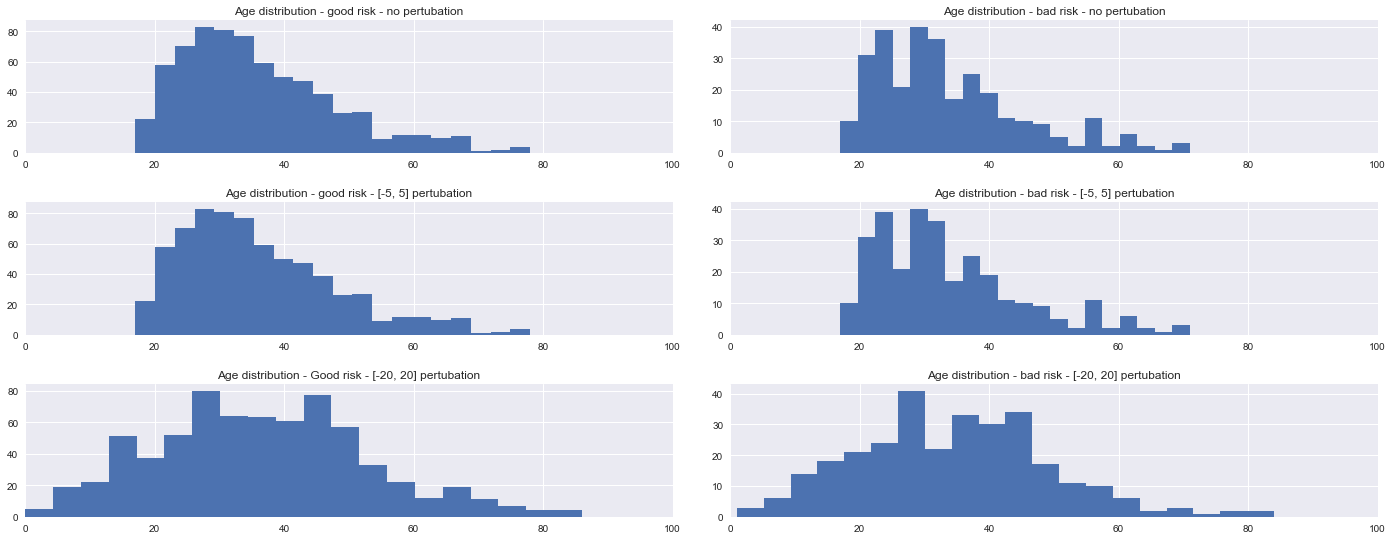

In [6]:
age_good = df.Age[df.Risk=="good"]
age_bad = df.Age[df.Risk=="bad"]
age_5_good = caped_df.Age[caped_df.Risk=="good"]
age_5_bad = caped_df.Age[caped_df.Risk=="bad"]

perturb_age_intervall_20 = tfms.NumericPerturbation(dtype=dtypes.Integer, min=-20, max=20)
age_20 = perturb_age_intervall_20(df.Age)
age_20_good = age_20[caped_df.Risk=="good"]
age_20_bad = age_20[caped_df.Risk=="bad"]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 8)) 
fig.tight_layout(pad=3.0)
ax[0][0].hist(age_good, bins=20)
ax[0][0].set_xlim((0, 100))
ax[0][0].set_title('Age distribution - good risk - no pertubation') 

ax[0][1].hist(age_bad, bins=20)
ax[0][1].set_xlim((0, 100))
ax[0][1].set_title('Age distribution - bad risk - no pertubation') 

ax[1][0].hist(age_5_good, bins=20)
ax[1][0].set_xlim((0, 100))
ax[1][0].set_title('Age distribution - good risk - [-5, 5] pertubation')

ax[1][1].hist(age_5_bad, bins=20)
ax[1][1].set_xlim((0, 100))
ax[1][1].set_title('Age distribution - bad risk - [-5, 5] pertubation')

ax[2][0].hist(age_20_good, bins=20)
ax[2][0].set_xlim((0, 100))
ax[2][0].set_title('Age distribution - Good risk - [-20, 20] pertubation')

ax[2][1].hist(age_20_bad, bins=20)
ax[2][1].set_xlim((0, 100))
ax[2][1].set_title('Age distribution - bad risk - [-20, 20] pertubation')

plt.show()

## Apply Data Privacy Policy

Transparency and collaboration are critical if we want to apply privacy techniques effectively. Once you have figured out which transformations you’d like to apply to the different fields, you can express the exact same transformations in a data policy file:

In [7]:
!cat ./policy/credit_policy.yaml

label: credit_policy
version: 1
rules:
  - match:
      name: Name
    actions:
      - transform:
          type: "tokenizer"
  - match:
      name: Sex
    actions:
      - transform:
          type: "tokenizer"
          max_token_len: 10
  - match:
      name: Age
    actions:
      - transform:
          type: "numeric-perturbation"
          dtype: Integer
          min: -5
          max: 5
  - match:
      name: Salary
    actions:
      - transform:
          type: "numeric-rounding"
          dtype: Double
          precision: -3
  - match:
      name: Application_date
    actions:
      - transform:
          type: "date-perturbation"
          frequency: DAY
          min: -3
          max: 3
  - match:
      name: City
    actions:
      - transform:
          type: "column-redact"
          columns: ["City"] 
  - match:
      name: Street_address
    actions:
      - transform:
          type: "column-redact"
          columns: ["Street_address"] 





For more information about how to write a policy, you can read the documentation [here](https://docs.capeprivacy.com/libraries/cape-python/policies/).

Once you have written your policy, it can be applied to your Pandas dataframe with only two lines of codes:

In [8]:
policy = cape.parse_policy("policy/credit_policy.yaml")
caped_df = cape.apply_policy(policy, df)

caped_df.head()

,Name,Salary,Application_date,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,e726d64beeb0f64ecb0d4a5f881d8240bd2c1b88a7bc94...,37000.0,2018-08-05,71,c4fb1e34dd,2,own,NaN,little,1169,6,radio/TV,good
1,779a0677ac3e9c7b53749ada726782eee1e505b0689691...,88000.0,2018-08-09,20,77bf0672e1,2,own,little,moderate,5951,48,radio/TV,bad
2,89baec12d4e58e22d18b31da4d0c753ebf15b493cad650...,41000.0,2018-05-16,52,c4fb1e34dd,1,own,little,NaN,2096,12,education,good
3,c2fc9b88c06c7ce48b3d2c66694e6bd5b82a3841072b26...,36000.0,2018-04-28,46,c4fb1e34dd,2,free,little,little,7882,42,furniture/equipment,good
4,ef128003d99247290244fb5dd1672bb2a54842542bab0c...,41000.0,2018-05-23,59,c4fb1e34dd,2,free,little,little,4870,24,car,bad
